# 8.2 Exercises: Hypothesis Testing and Linear Regression
# Rahul Rajeev

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
import numpy as np
import random
import thinkstats2
import thinkplot

Downloaded thinkstats2.py
Downloaded thinkplot.py


In [2]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)
import first

live, firsts, others = first.MakeFrames()
data = firsts.prglngth.values, others.prglngth.values

Downloaded nsfg.py
Downloaded first.py
Downloaded 2002FemPreg.dct
Downloaded 2002FemPreg.dat.gz


**9.1 Exercise:** As sample size increases, the power of a hypothesis test increases, which means it is more likely to be positive if the effect is real. Conversely, as sample size decreases, the test is less likely to be positive even if the effect is real.

To investigate this behavior, run the tests in this chapter with different subsets of the NSFG data. You can use `thinkstats2.SampleRows` to select a random subset of the rows in a DataFrame.

What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

In [36]:
# testing base case using 1000 iterations
iters = 1000
n = len(live)
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

In [37]:
# diff means in pregnancy length

data1 = firsts.prglngth.values, others.prglngth.values
ht1 = DiffMeansPermute(data1)
p1 = ht1.PValue(iters)

In [38]:
# diff means in weight

data2 = (firsts.totalwgt_lb.dropna().values,
        others.totalwgt_lb.dropna().values)
ht2 = DiffMeansPermute(data2)
p2 = ht2.PValue(iters)

In [39]:
# correlation between pregnancy age and weight

live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
data3 = live2.agepreg.values, live2.totalwgt_lb.values
ht3 = CorrelationPermute(data3)
p3 = ht3.PValue(iters)

In [40]:
# chi-square pregnancy length comparison

data4 = firsts.prglngth.values, others.prglngth.values
ht4 = PregLengthTest(data4)
p4 = ht4.PValue(iters)

In [41]:
print(n, p1, p2, p3, p4)

9148 0.157 0.0 0.0 0.0


In [58]:
def runTest(live, iterations):
    n = len(live)
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]
    
    data1 = firsts.prglngth.values, others.prglngth.values
    ht1 = DiffMeansPermute(data1)
    p1 = ht1.PValue(iterations)
    
    data2 = (firsts.totalwgt_lb.dropna().values,
            others.totalwgt_lb.dropna().values)
    ht2 = DiffMeansPermute(data2)
    p2 = ht2.PValue(iterations)
    
    live2 = live.dropna(subset=['agepreg', 'totalwgt_lb'])
    data3 = live2.agepreg.values, live2.totalwgt_lb.values
    ht3 = CorrelationPermute(data3)
    p3 = ht3.PValue(iterations)
    
    data4 = firsts.prglngth.values, others.prglngth.values
    ht4 = PregLengthTest(data4)
    p4 = ht4.PValue(iterations)
    
    print(n, '|', p1, '|', p2, '|', p3, '|', p4)

In [59]:
# running the tests for samples of increasing size up to around the length of the dataset
i = len(live)
print('n | p1 | p2 | p3 | p4')
while i >= 10:
    sample = thinkstats2.SampleRows(live, i)
    runTest(sample, 1000)
    i//=2

n | p1 | p2 | p3 | p4
9148 | 0.159 | 0.0 | 0.0 | 0.0
4574 | 0.01 | 0.002 | 0.0 | 0.0
2287 | 0.482 | 0.057 | 0.002 | 0.0
1143 | 0.456 | 0.079 | 0.046 | 0.366
571 | 0.743 | 0.231 | 0.184 | 0.163
285 | 0.498 | 0.323 | 0.008 | 0.59
142 | 0.214 | 0.625 | 0.666 | 0.505
71 | 0.742 | 0.323 | 0.224 | 0.764
35 | 0.085 | 0.024 | 0.391 | 0.0
17 | 0.459 | 0.588 | 0.794 | 0.0


<ipython-input-23-7ea16e8fdd92>:26: RuntimeWarning: invalid value encountered in true_divide
  stat = sum((observed - expected)**2 / expected)


**Q:** What happens to the p-values of these tests as sample size decreases? What is the smallest sample size that yields a positive test?

Most tests that are positive with large sample sizes become more negative as we take away values. However, there are some p-values that increase with samples taken away with smaller sample sizes. 

**10.1 Exercise:** Using the data from the BRFSS, compute the linear least squares fit for log(weight) versus height. How would you best present the estimated parameters for a model like this where one of the variables is log-transformed? If you were trying to guess someone’s weight, how much would it help to know their height?

Like the NSFG, the BRFSS oversamples some groups and provides a sampling weight for each respondent. In the BRFSS data, the variable name for these weights is totalwt. Use resampling, with and without weights, to estimate the mean height of respondents in the BRFSS, the standard error of the mean, and a 90% confidence interval. How much does correct weighting affect the estimates?

Read the BRFSS data and extract heights and log weights.

In [43]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [42]:
import brfss

df = brfss.ReadBrfss(nrows=None)
df = df.dropna(subset=['htm3', 'wtkg2'])
heights, weights = df.htm3, df.wtkg2
log_weights = np.log10(weights)

Estimate intercept and slope.

In [45]:
intercept, slope = thinkstats2.LeastSquares(heights, log_weights)
intercept, slope

(0.9930804163918215, 0.005281454169417753)

Make a scatter plot of the data and show the fitted line.

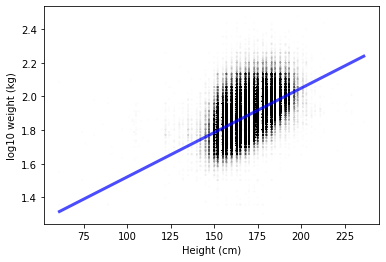

In [49]:
thinkplot.Scatter(heights, log_weights, color = 'black', alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, intercept, slope)
thinkplot.Plot(fxs, fys, color='blue')
thinkplot.Config(xlabel='Height (cm)', ylabel='log10 weight (kg)', legend=False)

Make the same plot but apply the inverse transform to show weights on a linear (not log) scale.

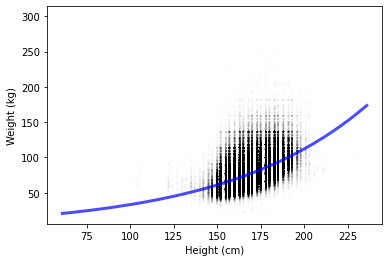

In [51]:
thinkplot.Scatter(heights, weights, color = 'black', alpha=0.01, s=5)
fxs, fys = thinkstats2.FitLine(heights, intercept, slope)
thinkplot.Plot(fxs, 10**fys, color='blue')
thinkplot.Config(xlabel='Height (cm)', ylabel='Weight (kg)', legend=False)

Plot percentiles of the residuals.

In [53]:
# creating residuals
residuals = thinkstats2.Residuals(heights, log_weights, intercept, slope)
df['residual'] = residuals

# creating bins and groups grouped by indices
bins = np.arange(130, 210, 5)
indices = np.digitize(df.htm3, bins)
groups = df.groupby(indices)

In [ ]:
# lists of weights and cdfs, cutting off the first and last ones
means = [group.htm3.mean() for i, group in groups][1:-1]
cdfs = [thinkstats2.Cdf(group.residual) for i, group in groups][1:-1]

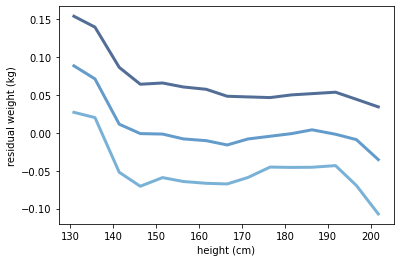

In [66]:
# plotting the residual plots
for percent in [75, 50, 25]:
    ress = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(means, ress, label=label)
    
thinkplot.Config(xlabel='height (cm)', 
                 ylabel='residual weight (kg)', 
                 legend=False)

Compute correlation.

In [55]:
rho = thinkstats2.Corr(heights, log_weights)
rho

0.5317282605983414

Compute coefficient of determination.

In [61]:
r2 = thinkstats2.CoefDetermination(log_weights, residuals)
r2

0.2827349431189399

Confirm that $R^2 = \rho^2$.

In [65]:
print(rho**2, r2)

0.2827349431189377 0.2827349431189399


**A:** Close enough!

Compute Std(ys), which is the RMSE of predictions that don't use height.

In [70]:
std_ys = thinkstats2.Std(log_weights)
std_ys

0.10320725030004888

Compute Std(res), the RMSE of predictions that do use height.

In [71]:
std_res = thinkstats2.Std(residuals)
std_res

0.08740777080416084

How much does height information reduce RMSE?

In [72]:
1 - std_res / std_ys

0.15308497658793407

Use resampling to compute sampling distributions for inter and slope.

In [78]:
t_values = []
for i in range(100):
    sample = thinkstats2.ResampleRows(df)
    estimates = thinkstats2.LeastSquares(sample.htm3, np.log10(sample.wtkg2))
    t_values.append(estimates)

intercepts, slopes = zip(*t_values)

Plot the sampling distribution of slope.

{'xscale': 'linear', 'yscale': 'linear'}

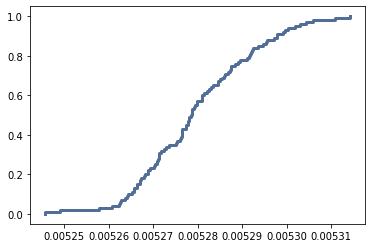

In [79]:
cdf = thinkstats2.Cdf(slopes)
thinkplot.Cdf(cdf)

Compute the p-value of the slope.

In [80]:
pvalue = cdf[0]
pvalue

0

Compute the 90% confidence interval of slope.

In [81]:
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(0.005262439556339632, 0.005301938419593701)

Compute the mean of the sampling distribution.

In [82]:
mean = thinkstats2.Mean(slopes)
mean

0.005279805169515126

Compute the standard deviation of the sampling distribution, which is the standard error.

In [84]:
stde = thinkstats2.Std(slopes)
stde

1.2930833479356284e-05

Resample rows without weights, compute mean height, and summarize results.

In [85]:
estimates_unweighted = [thinkstats2.ResampleRows(df).htm3.mean() for i in range(100)]
Summarize(estimates_unweighted)

mean, SE, CI 168.95476924553853 0.01768934893916453 (168.92370247983993, 168.98501384425717)


Resample rows with weights.  Note that the weight column in this dataset is called `finalwt`.

In [62]:
estimates_weighted = [ResampleRowsWeighted(df, 'finalwt').htm3.mean() for _ in range(100)]
Summarize(estimates_weighted)

mean, SE, CI 170.497191940015 0.018612452321638048 (170.46966137149093, 170.52532892742374)
